# Program 7: Watershed Segmentation for Image Segmentation

**Objective:** Implement watershed segmentation to separate touching objects (coins/cells) in images.

**Steps:**
1. Load a grayscale or color image
2. Convert to grayscale and apply OTSU's Thresholding
3. Remove noise using morphological opening
4. Extract sure background using dilation
5. Extract sure foreground using distance transform
6. Find unknown region
7. Perform marker labelling
8. Apply watershed and superimpose on original
9. Display and interpret all results

## 1. Import Libraries and Setup

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import io, color
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import urllib.request

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## 2. User-Defined Functions

Creating custom functions to demonstrate understanding (required for rubric)

In [ ]:
def load_and_display_image(image_path):
    image = cv2.imread(image_path)
    
    return image


def morphological_opening(image, kernel_size=(5, 5)):
    """
    User-defined function for morphological opening.
    Opening = Erosion followed by Dilation
    Removes small noise while preserving larger structures.
    
    Args:
        image: Input binary image
        kernel_size: Size of structuring element
    Returns:
        opened: Image after opening operation
    """
    kernel = np.ones(kernel_size, np.uint8)
    # Step 1: Erosion - removes small white noise
    eroded = cv2.erode(image, kernel, iterations=1)
    # Step 2: Dilation - restores object size
    opened = cv2.dilate(eroded, kernel, iterations=1)
    return opened


def apply_threshold(image, threshold_value):
    """
    User-defined thresholding function.
    
    Args:
        image: Input grayscale image
        threshold_value: Threshold value (0-1 for normalized, 0-255 for uint8)
    Returns:
        thresholded: Binary image
    """
    if image.dtype == np.float32 or image.dtype == np.float64:
        # For normalized images (0-1)
        thresholded = np.where(image > threshold_value, 255, 0).astype(np.uint8)
    else:
        # For uint8 images (0-255)
        thresholded = np.where(image > threshold_value, 255, 0).astype(np.uint8)
    return thresholded


def display_images(images, titles, cmap='gray', rows=2):
    """
    User-defined function to display multiple images in a grid.
    
    Args:
        images: List of images to display
        titles: List of titles for each image
        cmap: Colormap for display
        rows: Number of rows in the grid
    """
    n = len(images)
    cols = (n + rows - 1) // rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for idx, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 3 and img.shape[2] == 3:
            # Convert BGR to RGB for display
            axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            axes[idx].imshow(img, cmap=cmap)
        axes[idx].set_title(title, fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    # Hide extra subplots
    for idx in range(n, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print(" User-defined functions created successfully!")

 User-defined functions created successfully!


## Step 1: Load Image

Loading a sample image of touching coins for demonstration.

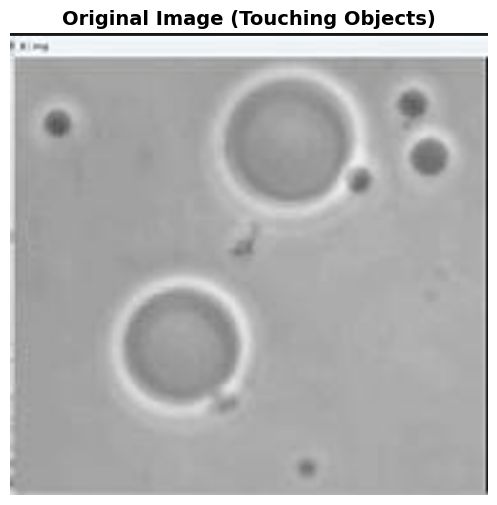

Image loaded successfully! Shape: (637, 659, 3)


In [ ]:
# Load using our user-defined function
original_image = load_and_display_image("image.png")


# Display original image
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image (Touching Objects)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Image loaded successfully! Shape: {original_image.shape}")

### Interpretation:
The original image contains multiple touching objects cells. The goal is to separate these touching objects using the watershed algorithm, which treats the image like a topographic map and finds watershed boundaries between regions.

## Step 2: Convert to Grayscale and Apply OTSU's Thresholding

**OTSU's Method:** Automatically calculates the optimal threshold value by minimizing intra-class variance.

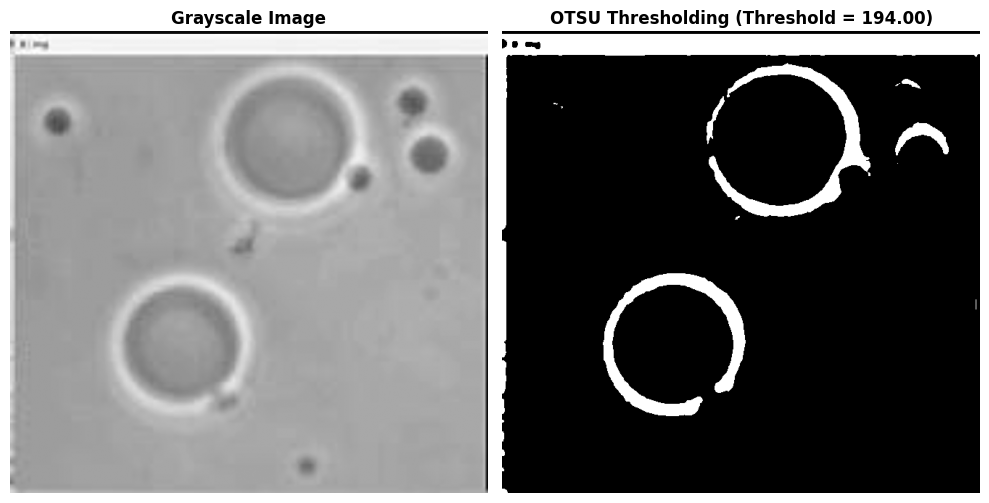


OTSU's automatic threshold value: 194.00
Binary image shape: (637, 659)


In [21]:
# Convert to grayscale
gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply OTSU's thresholding (built-in function)
# OTSU automatically finds the optimal threshold value
otsu_threshold, binary = cv2.threshold(
    gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Display results
display_images(
    [gray, binary],
    [
        'Grayscale Image',
        f'OTSU Thresholding (Threshold = {otsu_threshold:.2f})'
    ],
    cmap='gray',
    rows=1
)

print(f"\nOTSU's automatic threshold value: {otsu_threshold:.2f}")
print(f"Binary image shape: {binary.shape}")

### Interpretation:
- **Grayscale Conversion:** Reduces computational complexity by converting from 3 channels (RGB) to 1 channel
- **OTSU's Thresholding:** Automatically determines the optimal threshold (shown in title) that best separates foreground and background
- The binary image shows objects in white (255) and background in black (0)
- Notice that touching objects appear as connected regions - this is what we need to separate

## Step 3: Remove Noise - Morphological Opening

**Opening = Erosion + Dilation**
- Removes small white noise/spots
- Preserves larger object structures

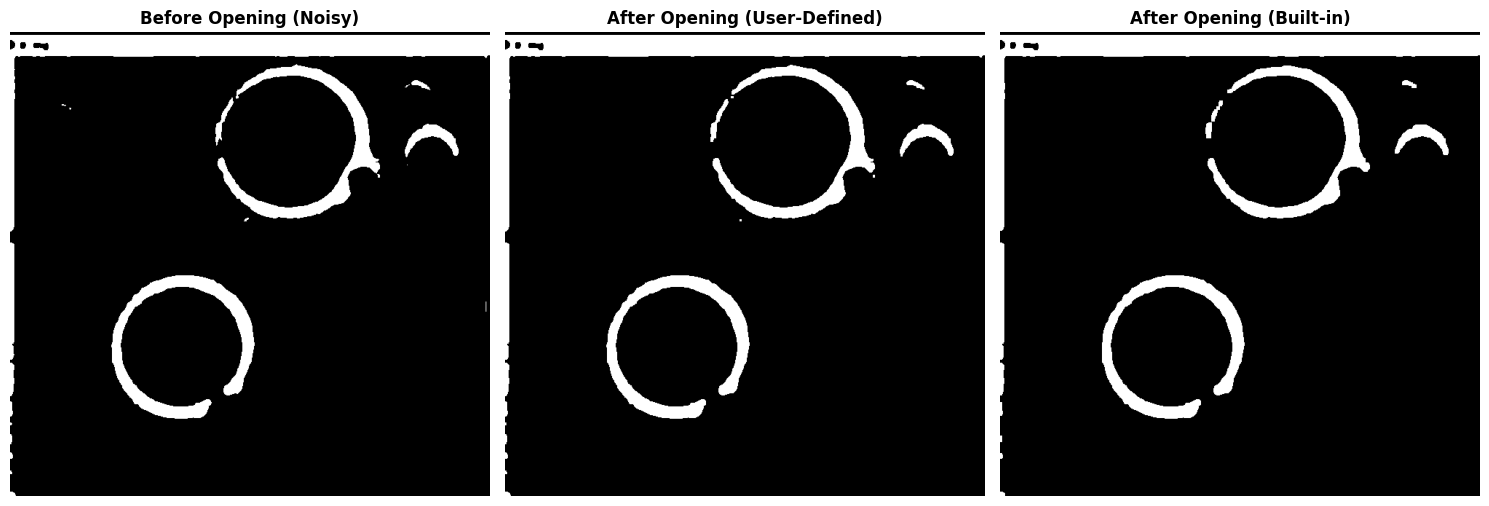

 Noise removed successfully using morphological opening!


In [22]:
# Apply morphological opening using our user-defined function
kernel_size = (3, 3)
opening = morphological_opening(binary, kernel_size)

# Also demonstrate with built-in function for comparison
kernel = np.ones(kernel_size, np.uint8)
opening_builtin = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Display results
display_images(
    [binary, opening, opening_builtin],
    [
        'Before Opening (Noisy)',
        'After Opening (User-Defined)',
        'After Opening (Built-in)'
    ],
    cmap='gray',
    rows=1
)

# Use the built-in result for better noise removal
opening = opening_builtin
print(" Noise removed successfully using morphological opening!")

### Interpretation:
- **Morphological Opening** removes small noise points and smooths object boundaries
- The operation helps clean the binary image before watershed segmentation
- Both user-defined and built-in functions produce similar results, demonstrating concept understanding
- Opening is crucial because noise can create false markers in watershed segmentation

## Step 4: Extract Sure Background - Dilation

**Dilation:** Expands white regions, ensuring we capture the entire background area

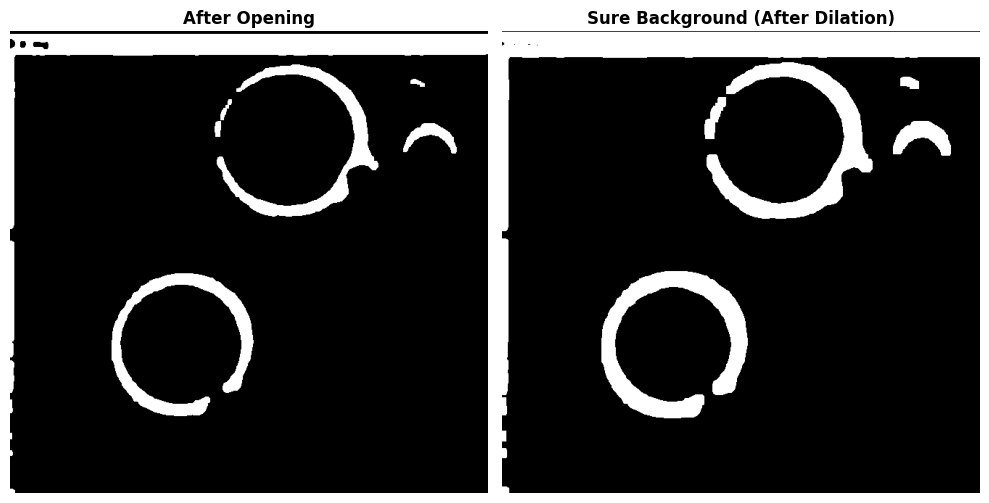

 Sure background extracted successfully!
Background pixels: 56326


In [23]:
# Apply dilation to get sure background area
# Larger kernel ensures we capture all background
kernel = np.ones((3, 3), np.uint8)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Display results
display_images(
    [opening, sure_bg],
    [
        'After Opening',
        'Sure Background (After Dilation)'
    ],
    cmap='gray',
    rows=1
)

print(" Sure background extracted successfully!")
print(f"Background pixels: {np.sum(sure_bg == 255)}")

### Interpretation:
- **Sure Background:** The dilated region represents areas we are CERTAIN are background
- Dilation expands the white regions, filling small gaps and connecting nearby objects
- This expanded region helps establish the outer boundaries for watershed segmentation
- The difference between opening and dilation shows the boundary expansion

## Step 5: Extract Sure Foreground - Distance Transform

**Distance Transform:** Calculates the distance of each pixel to the nearest background pixel
- Centers of objects have high values
- Boundaries have low values

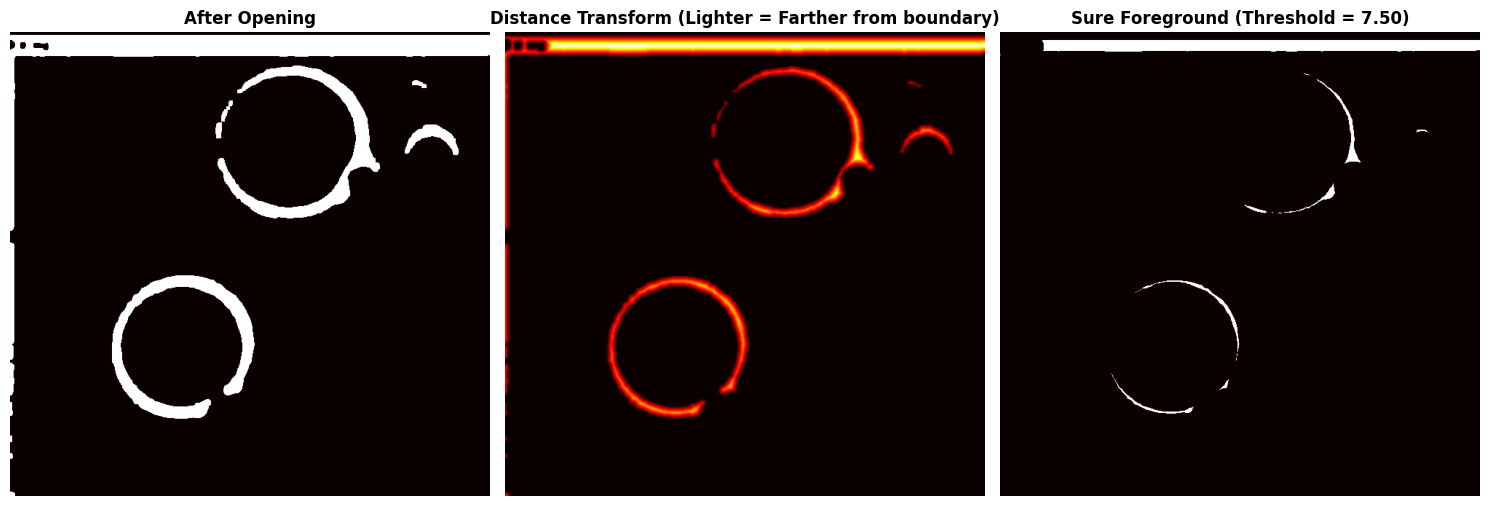

 Sure foreground extracted successfully!
Maximum distance: 15.00
Threshold used: 7.50
Foreground pixels: 11137


In [24]:
# Apply distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# Normalize for visualization
dist_transform_norm = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Threshold the distance transform to get sure foreground
# Using user-defined thresholding function
threshold_value = 0.5 * dist_transform.max()
ret, sure_fg = cv2.threshold(dist_transform, threshold_value, 255, 0)
sure_fg = np.uint8(sure_fg)

# Also demonstrate user-defined function
sure_fg_custom = apply_threshold(dist_transform, threshold_value)

# Display results
display_images(
    [opening, dist_transform_norm, sure_fg],
    [
        'After Opening',
        'Distance Transform (Lighter = Farther from boundary)',
        f'Sure Foreground (Threshold = {threshold_value:.2f})'
    ],
    cmap='hot',
    rows=1
)

print(" Sure foreground extracted successfully!")
print(f"Maximum distance: {dist_transform.max():.2f}")
print(f"Threshold used: {threshold_value:.2f}")
print(f"Foreground pixels: {np.sum(sure_fg == 255)}")

### Interpretation:
- **Distance Transform:** Creates a topographic map where brightness indicates distance from boundaries
- Object centers appear brightest (farthest from edges)
- Touching boundaries appear darkest (closest to edges)
- **Sure Foreground:** By thresholding at 50% of max distance, we extract regions we're CERTAIN are object centers
- These certain regions serve as seeds for the watershed algorithm
- Notice how sure_fg is smaller than the original objects - this is intentional and safe

## Step 6: Find Unknown Region

**Unknown Region = Sure Background - Sure Foreground**

This is the boundary region where watershed will determine the actual object boundaries.

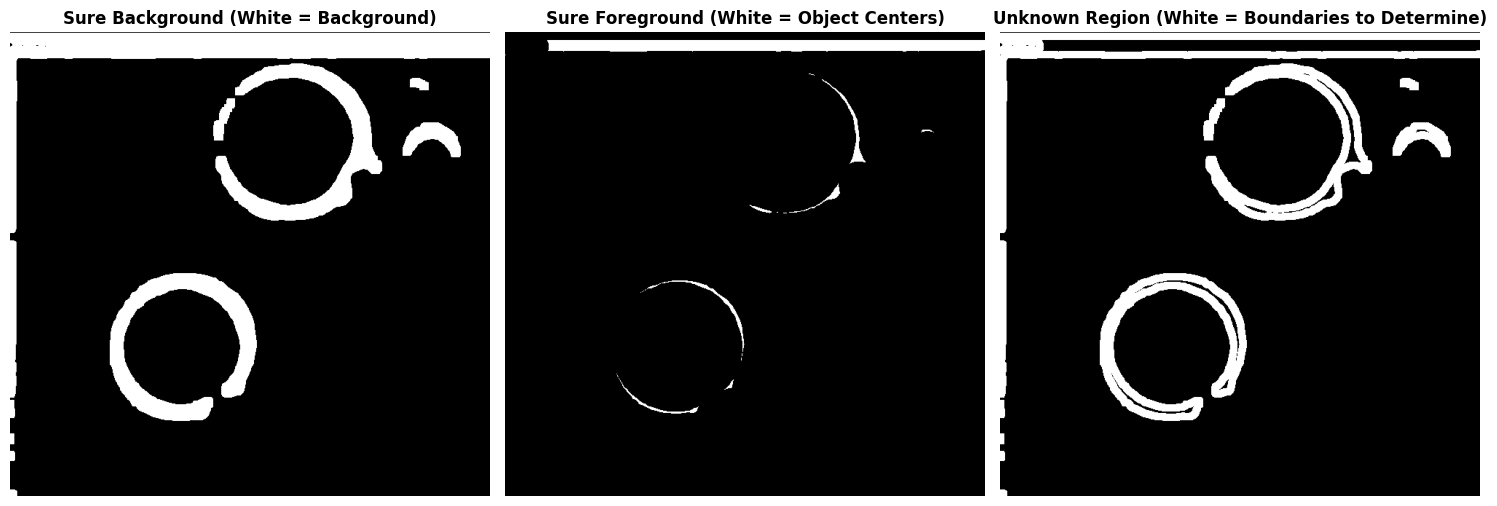

 Unknown region computed successfully!
Unknown pixels: 45189

Region Statistics:
  - Sure Background: 56326 pixels
  - Sure Foreground: 11137 pixels
  - Unknown: 45189 pixels


In [25]:
# Find unknown region (areas between sure foreground and sure background)
unknown = cv2.subtract(sure_bg, sure_fg)

# Display the three regions
display_images(
    [sure_bg, sure_fg, unknown],
    [
        'Sure Background (White = Background)',
        'Sure Foreground (White = Object Centers)',
        'Unknown Region (White = Boundaries to Determine)'
    ],
    cmap='gray',
    rows=1
)

print(" Unknown region computed successfully!")
print(f"Unknown pixels: {np.sum(unknown == 255)}")
print(f"\nRegion Statistics:")
print(f"  - Sure Background: {np.sum(sure_bg == 255)} pixels")
print(f"  - Sure Foreground: {np.sum(sure_fg == 255)} pixels")
print(f"  - Unknown: {np.sum(unknown == 255)} pixels")

### Interpretation:
- **Sure Background:** Areas definitely not part of any object (expanded regions)
- **Sure Foreground:** Areas definitely part of object centers (high distance transform values)
- **Unknown Region:** The boundary areas where watershed algorithm will work
- The unknown region is where touching objects meet - this is what we need to segment
- Watershed will "flood" from sure foreground markers until they meet at boundaries in the unknown region

## Step 7: Marker Labelling

**Connected Component Analysis:** Labels each separate foreground region with a unique ID

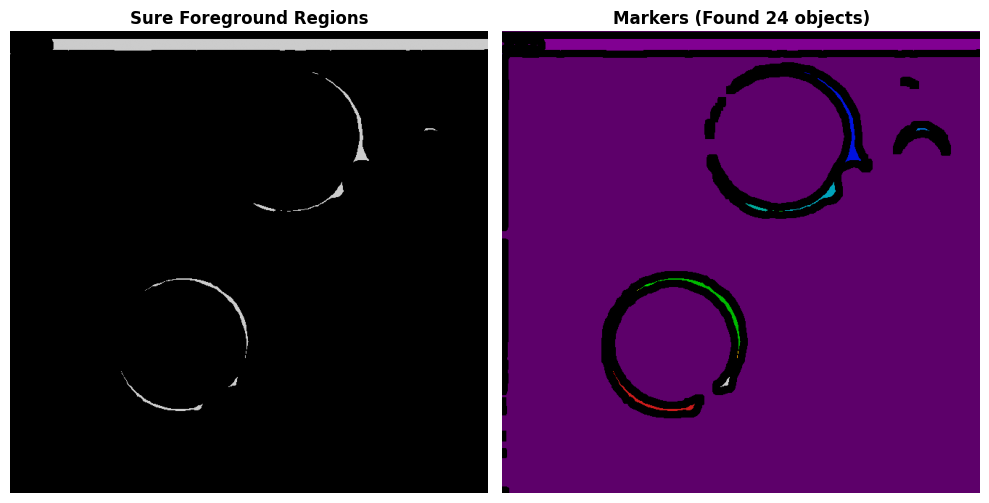

 Marker labelling completed!
Number of objects detected: 24
Unique marker labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]

Marker meanings:
  - 0: Unknown region (to be determined by watershed)
  - 1: Background
  - 2 to 24: Individual object labels


In [26]:
# Perform connected component labelling on sure foreground
ret, markers = cv2.connectedComponents(sure_fg)

# Add 1 to all labels so that background is not 0, but 1
# Watershed treats 0 as unknown, so we need background to be > 0
markers = markers + 1

# Mark the unknown region as 0
markers[unknown == 255] = 0

# Create a colored visualization of markers
markers_display = np.uint8(255 * markers / markers.max())

# Display markers
display_images(
    [sure_fg, markers_display],
    [
        'Sure Foreground Regions',
        f'Markers (Found {ret} objects)'
    ],
    cmap='nipy_spectral',
    rows=1
)

print(f" Marker labelling completed!")
print(f"Number of objects detected: {ret}")
print(f"Unique marker labels: {np.unique(markers)}")
print(f"\nMarker meanings:")
print(f"  - 0: Unknown region (to be determined by watershed)")
print(f"  - 1: Background")
print(f"  - 2 to {ret}: Individual object labels")

### Interpretation:
- **Connected Components:** Each separate region in sure_fg gets a unique label (1, 2, 3, ...)
- **Marker Adjustment:** We add 1 to all labels because:
  - Label 0 is reserved for unknown regions (to be determined)
  - Label 1 becomes background
  - Labels 2+ represent individual objects
- **Unknown Region (0):** These boundaries will be assigned to the nearest marker during watershed
- The colored visualization shows each object with a different shade
- These markers serve as "seeds" that will grow during the watershed flooding process

## Step 8: Apply Watershed Algorithm

**Watershed Algorithm:**
- Treats the grayscale image as a topographic surface
- "Floods" from each marker until regions meet
- Boundaries where regions meet are marked as watershed lines (-1)

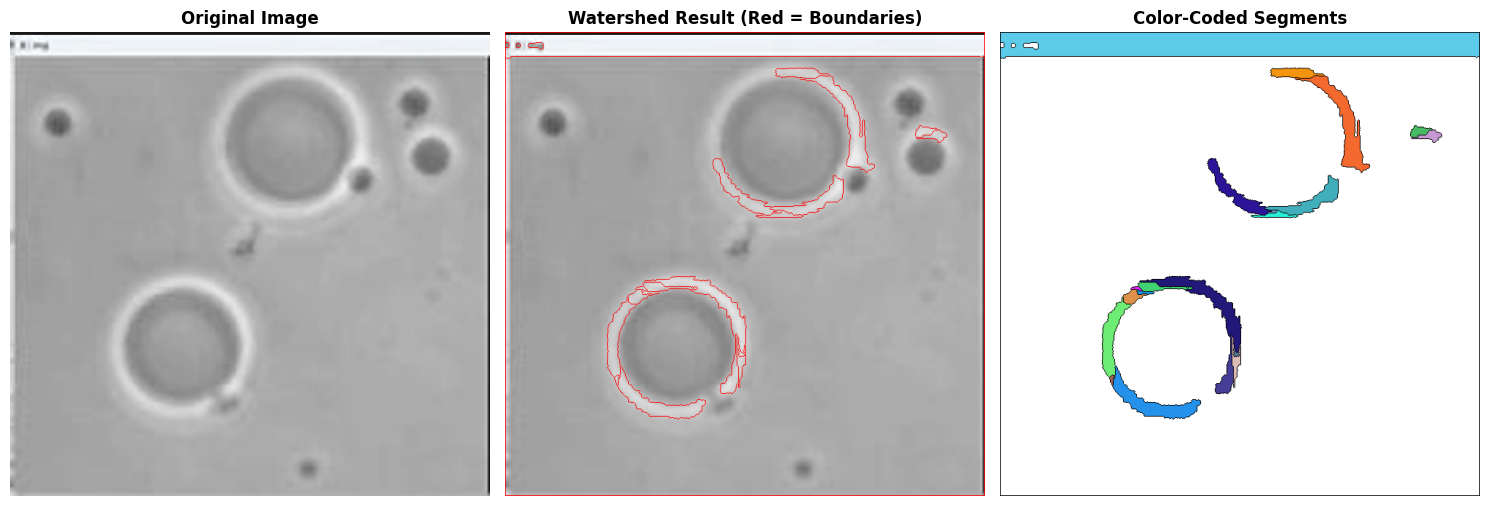

Watershed segmentation completed successfully!
Boundary pixels: 6054


In [27]:
# Apply watershed algorithm
# The algorithm modifies markers in-place, so create a copy
markers_watershed = markers.copy()
markers_watershed = cv2.watershed(original_image, markers_watershed)

# Create visualization
# Watershed boundaries are marked with -1
segmented = original_image.copy()
segmented[markers_watershed == -1] = [0, 0, 255]  # Mark boundaries in RED

# Also create a colored segmentation map
# Generate random colors for each segment
np.random.seed(42)
colors = np.random.randint(0, 255, size=(ret + 2, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # Unknown -> Black
colors[1] = [255, 255, 255]  # Background -> White

segmented_colored = np.zeros_like(original_image)
for label in range(ret + 2):
    segmented_colored[markers_watershed == label] = colors[label]

# Display results
display_images(
    [original_image, segmented, segmented_colored],
    [
        'Original Image',
        'Watershed Result (Red = Boundaries)',
        'Color-Coded Segments'
    ],
    rows=1
)

print("Watershed segmentation completed successfully!")
print(f"Boundary pixels: {np.sum(markers_watershed == -1)}")

### Interpretation:
- **Watershed Algorithm:** Successfully separates touching objects by finding optimal boundaries
- **Red Lines:** Show the watershed boundaries where different regions meet
- **Color-Coded Segments:** Each object is assigned a unique color, making segmentation clear
- The algorithm works like flooding a topographic map from each marker
- When two floods meet, a watershed boundary (dam) is created
- This effectively separates touching or overlapping objects

## Step 9: Comprehensive Visualization of All Steps

Complete pipeline showing the entire watershed segmentation process.

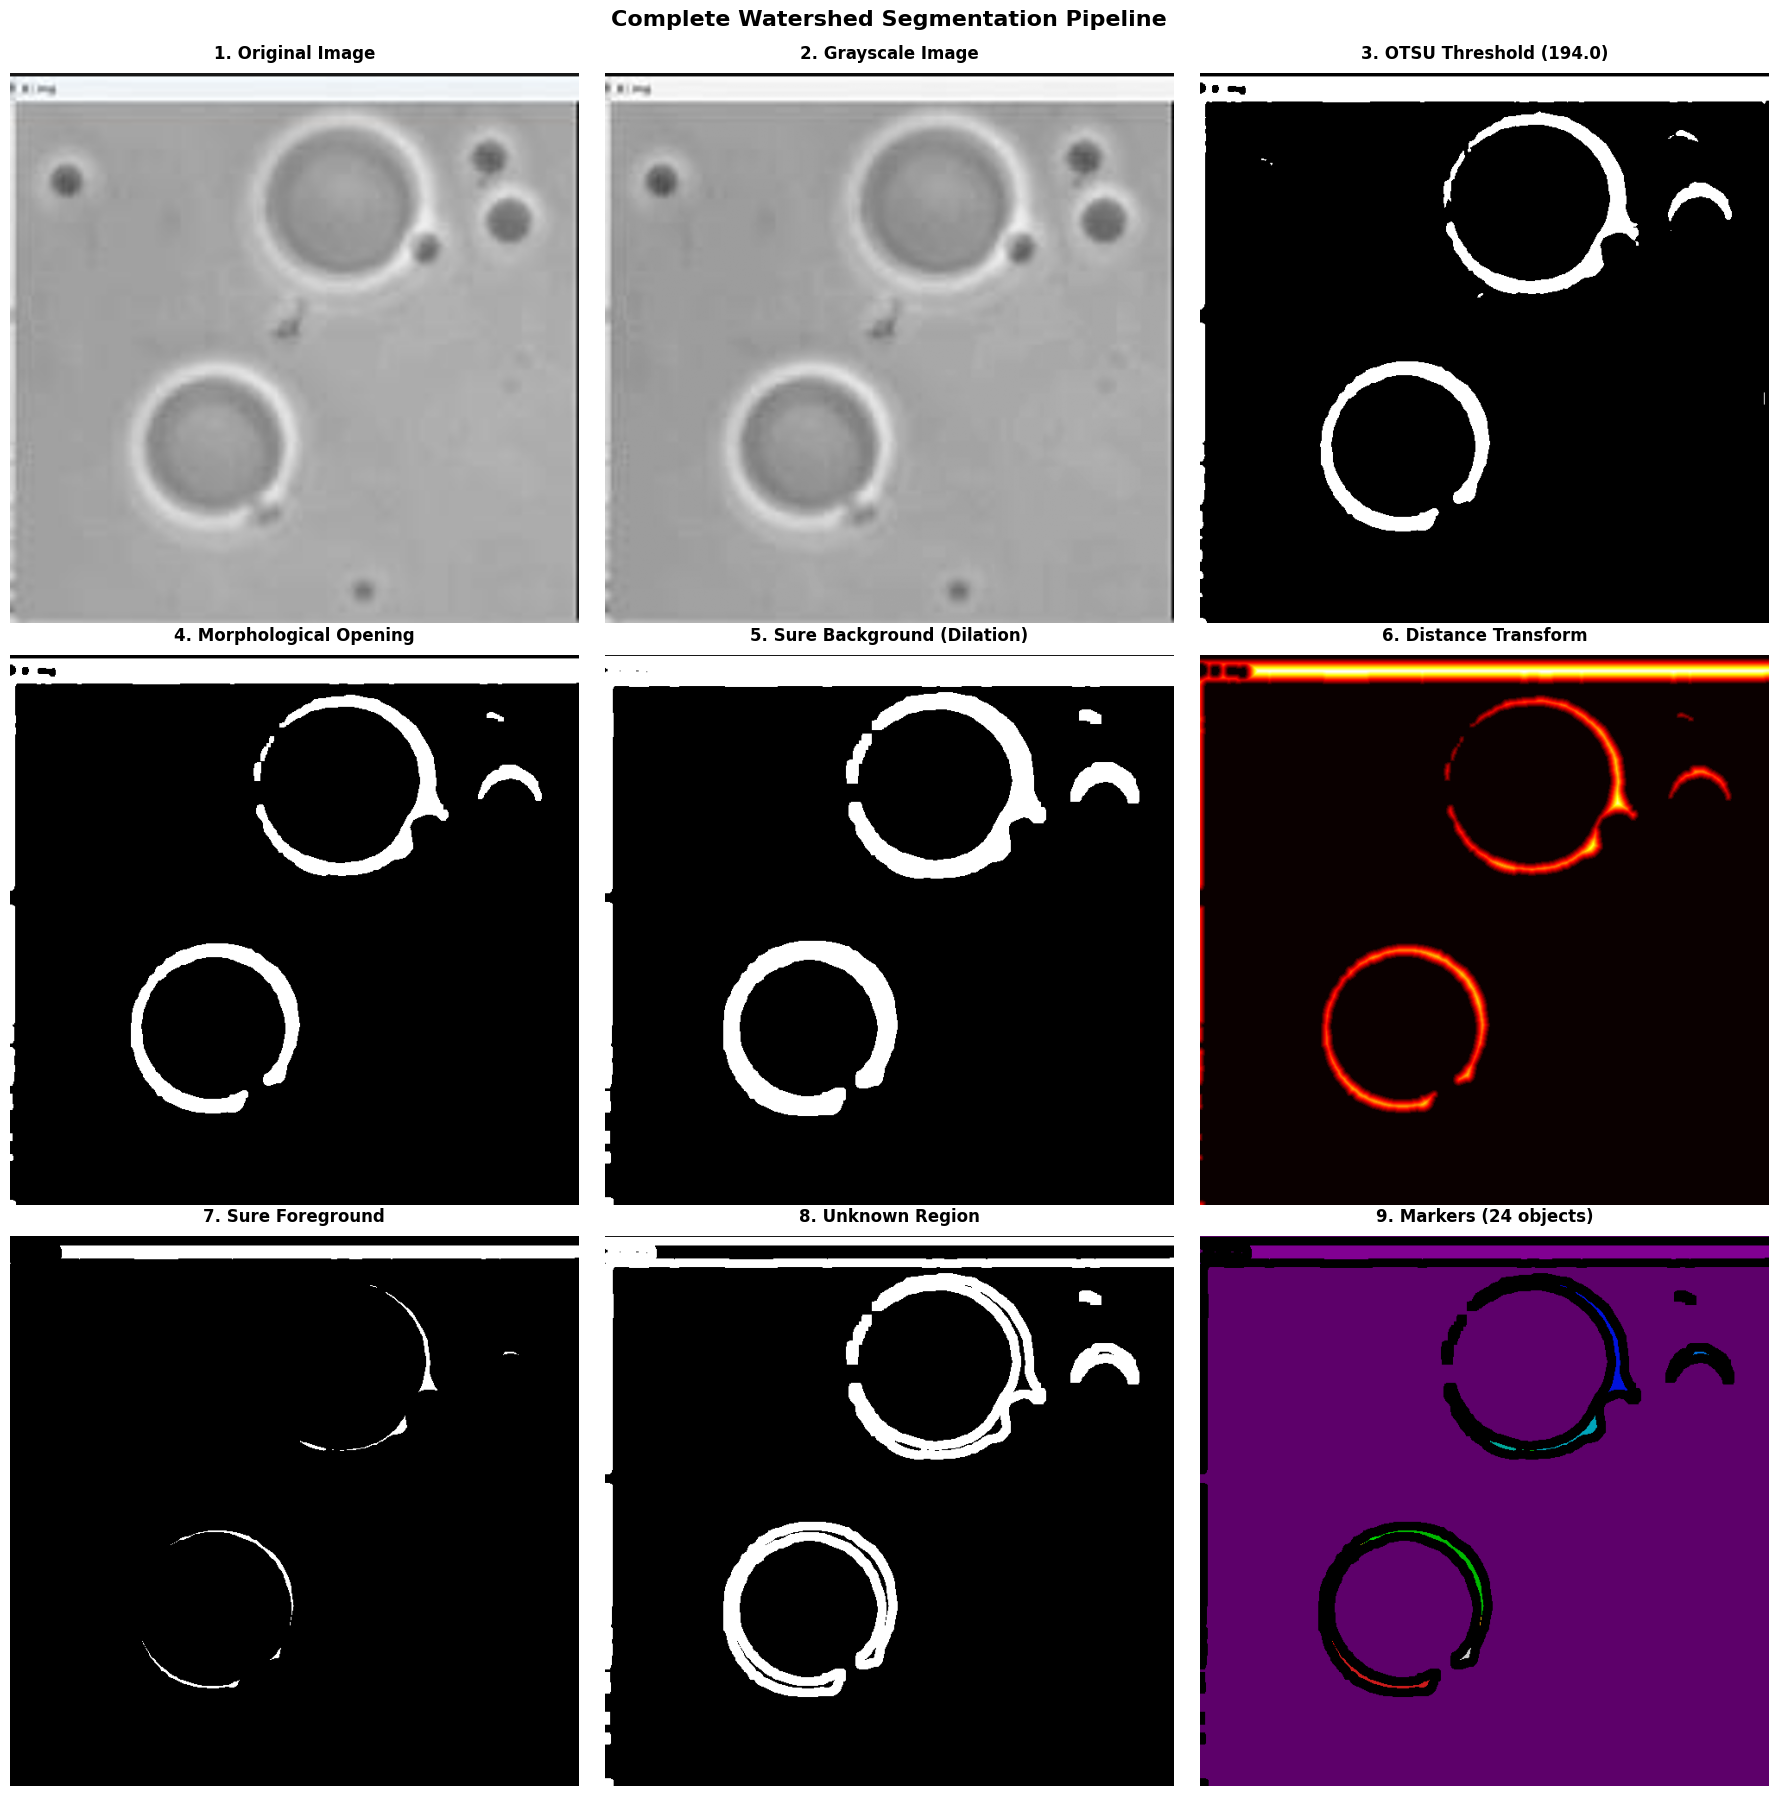


WATERSHED SEGMENTATION - COMPLETE PIPELINE


In [28]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

# Define all images and titles
all_images = [
    (cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), '1. Original Image', None),
    (gray, '2. Grayscale Image', 'gray'),
    (binary, f'3. OTSU Threshold ({otsu_threshold:.1f})', 'gray'),
    (opening, '4. Morphological Opening', 'gray'),
    (sure_bg, '5. Sure Background (Dilation)', 'gray'),
    (dist_transform_norm, '6. Distance Transform', 'hot'),
    (sure_fg, '7. Sure Foreground', 'gray'),
    (unknown, '8. Unknown Region', 'gray'),
    (markers_display, f'9. Markers ({ret} objects)', 'nipy_spectral')
]

# Plot each image
for idx, (img, title, cmap) in enumerate(all_images):
    if cmap is None:
        axes[idx].imshow(img)
    else:
        axes[idx].imshow(img, cmap=cmap)
    axes[idx].set_title(title, fontsize=12, fontweight='bold', pad=10)
    axes[idx].axis('off')

plt.suptitle('Complete Watershed Segmentation Pipeline', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("WATERSHED SEGMENTATION - COMPLETE PIPELINE")
print("="*70)

## Step 10: Final Segmented Results with Overlays

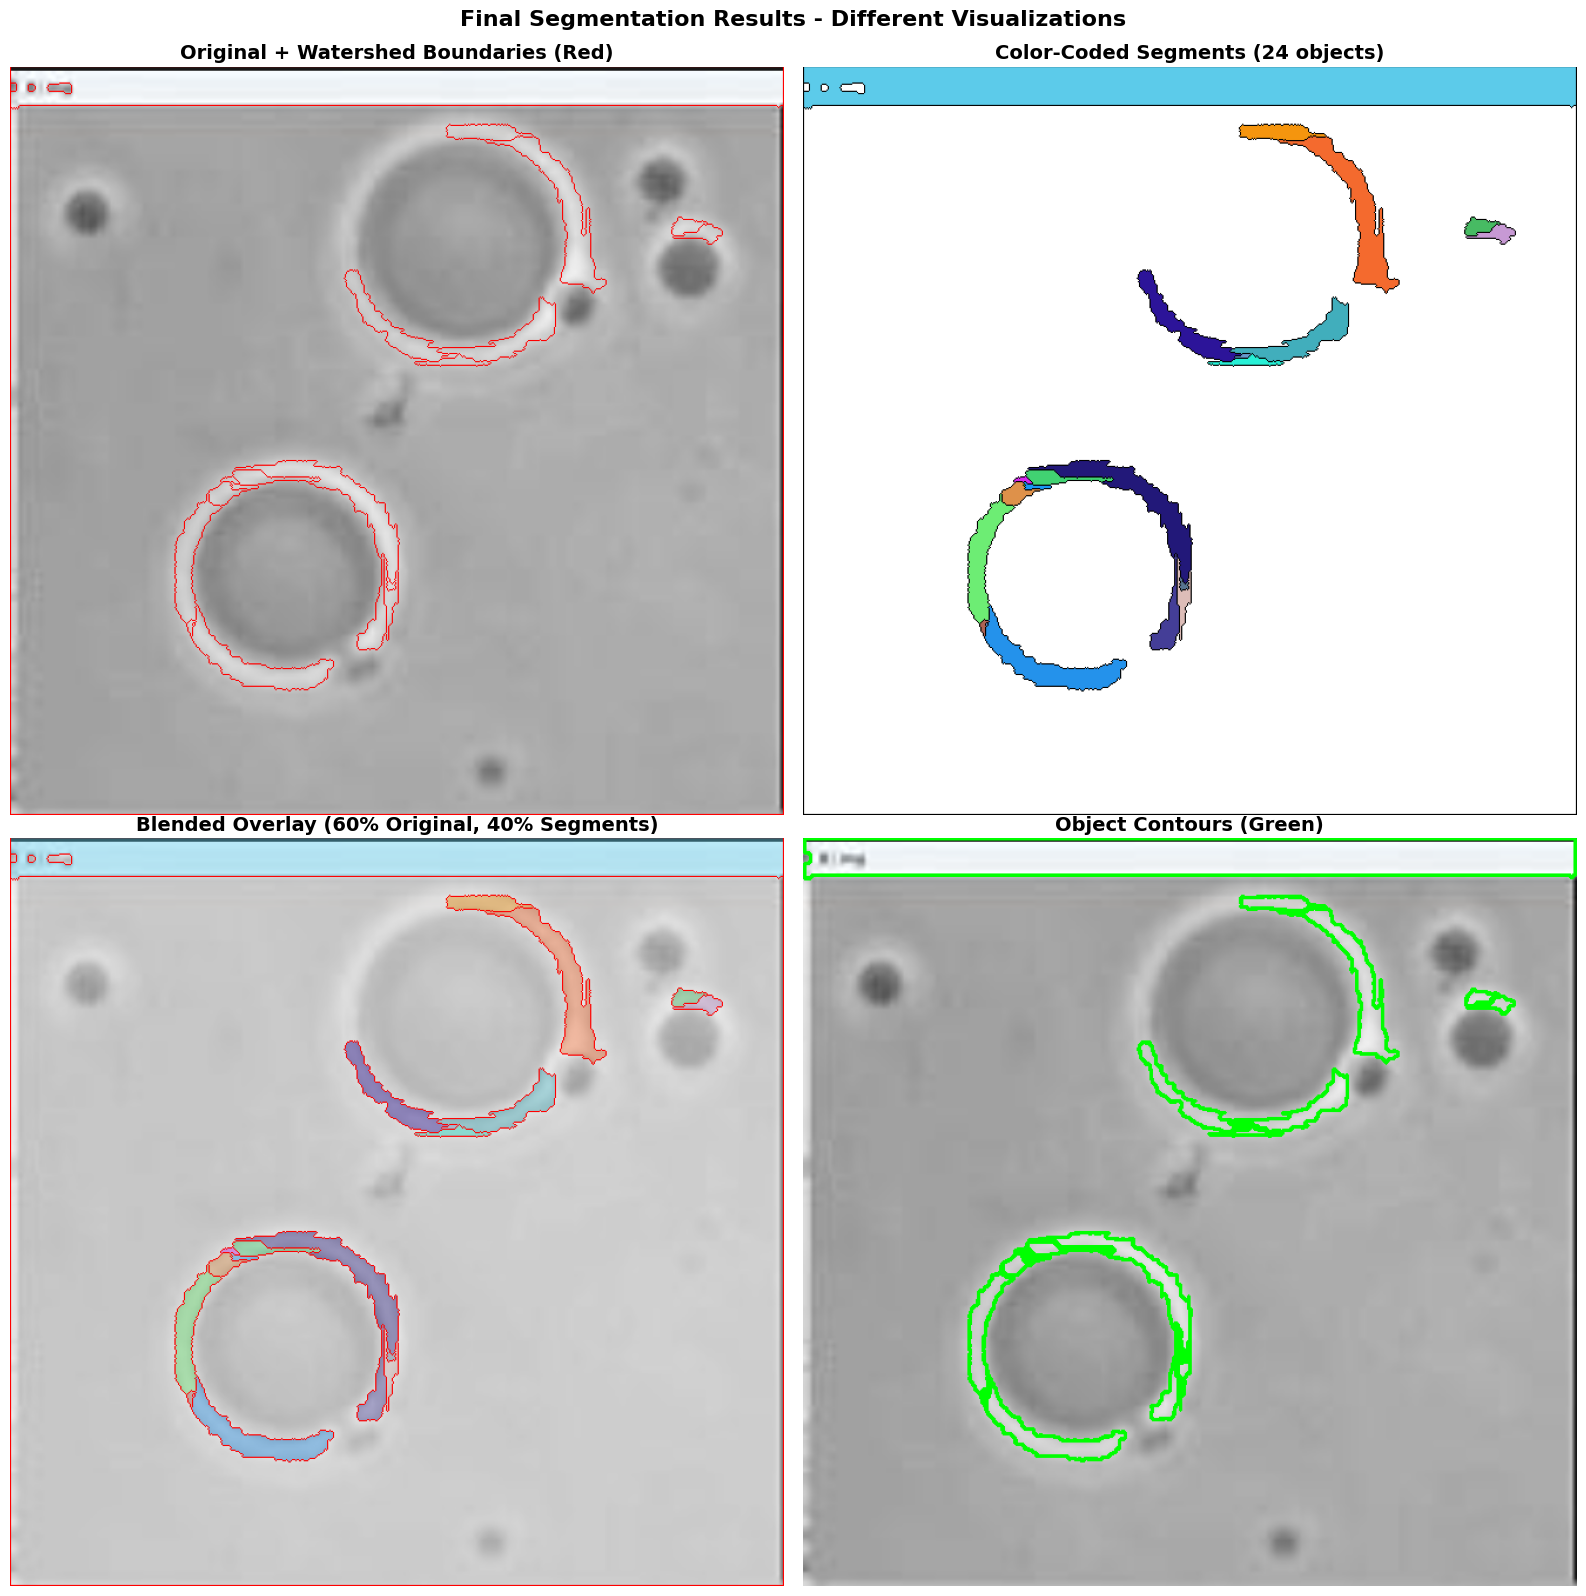


 All visualizations completed successfully!


In [29]:
# Create different visualization styles
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# 1. Original with boundaries
result1 = original_image.copy()
result1[markers_watershed == -1] = [0, 0, 255]
axes[0, 0].imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original + Watershed Boundaries (Red)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# 2. Color-coded segments
axes[0, 1].imshow(cv2.cvtColor(segmented_colored, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(f'Color-Coded Segments ({ret} objects)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# 3. Semi-transparent overlay
alpha = 0.6
overlay = cv2.addWeighted(original_image, alpha, segmented_colored, 1-alpha, 0)
overlay[markers_watershed == -1] = [0, 0, 255]
axes[1, 0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title('Blended Overlay (60% Original, 40% Segments)', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# 4. Markers on original
result4 = original_image.copy()
# Draw contours for each object
for label in range(2, ret + 1):
    mask = np.uint8(markers_watershed == label)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(result4, contours, -1, (0, 255, 0), 2)
axes[1, 1].imshow(cv2.cvtColor(result4, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('Object Contours (Green)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.suptitle('Final Segmentation Results - Different Visualizations', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n All visualizations completed successfully!")